In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
import os
from sklearn.cluster import KMeans
import geopandas as gpd
from shapely.geometry import Point
import folium

In [ ]:
def download_airport_dataset():
    url = "https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat"
    filename = 'airports.dat'


    if not os.path.exists(filename):
        try:
            urllib.request.urlretrieve(url, filename)
            print("Airport dataset downloaded successfully.")
        except Exception as e:
            print(f"Error downloading dataset: {e}")
            return None


    columns = [
        'airport_id', 'name', 'city', 'country', 'iata', 'icao',
        'latitude', 'longitude', 'altitude', 'timezone',
        'dst', 'tz_database_time_zone', 'type', 'source'
    ]


    df = pd.read_csv(filename, header=None, names=columns, encoding='latin-1')
    return df

In [ ]:
airports_df = download_airport_dataset()

In [ ]:
def preprocess_airport_data(df):

    df = df.dropna(subset=['latitude', 'longitude', 'altitude'])


    le = LabelEncoder()
    df['type_encoded'] = le.fit_transform(df['type'])


    features = ['latitude', 'longitude', 'altitude', 'type_encoded']
    X = df[features]


    y = (df['type'] == 'large_airport').astype(int)

    return X, y, le

In [ ]:
X, y, type_encoder = preprocess_airport_data(airports_df)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
def create_airport_classification_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(input_shape,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
model = create_airport_classification_model(X_train_scaled.shape[1])
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=0
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1540

    accuracy                           1.00      1540
   macro avg       1.00      1.00      1.00      1540
weighted avg       1.00      1.00      1.00      1540



In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12,4))


    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()


    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_geographical_distribution(df):
    plt.figure(figsize=(15,8))
    plt.scatter(df['longitude'], df['latitude'],
                c=df['altitude'],
                cmap='viridis',
                alpha=0.6)
    plt.colorbar(label='Altitude')
    plt.title('Geographical Distribution of Airports')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.tight_layout()
    plt.show()

In [ ]:
def kmeans_clustering(df, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df['cluster'] = kmeans.fit_predict(df[['latitude', 'longitude', 'altitude']])
    return df, kmeans

airports_df, kmeans = kmeans_clustering(airports_df)

In [ ]:
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def plot_clusters_on_map(df, kmeans):

    df['cluster'] = kmeans.labels_


    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']))


    cmap = plt.cm.get_cmap('tab20', len(df['cluster'].unique()))

    plt.figure(figsize=(20, 15))
    ax = gdf.plot(column='cluster', cmap=cmap, legend=True, alpha=0.6, markersize=50, legend_kwds={'label': "Cluster"})


    plt.title('Airport Clusters by Geographical Location', fontsize=16)
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    plt.tight_layout()


    plt.show()

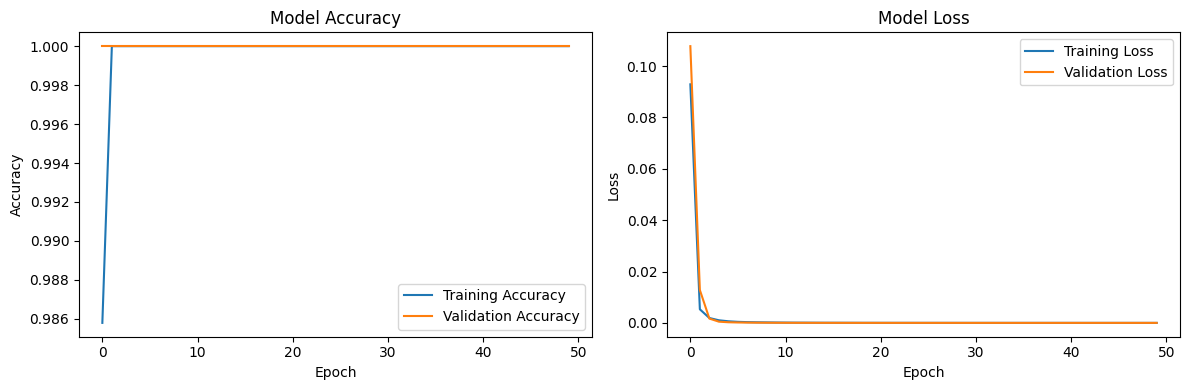

In [ ]:
plot_training_history(history)

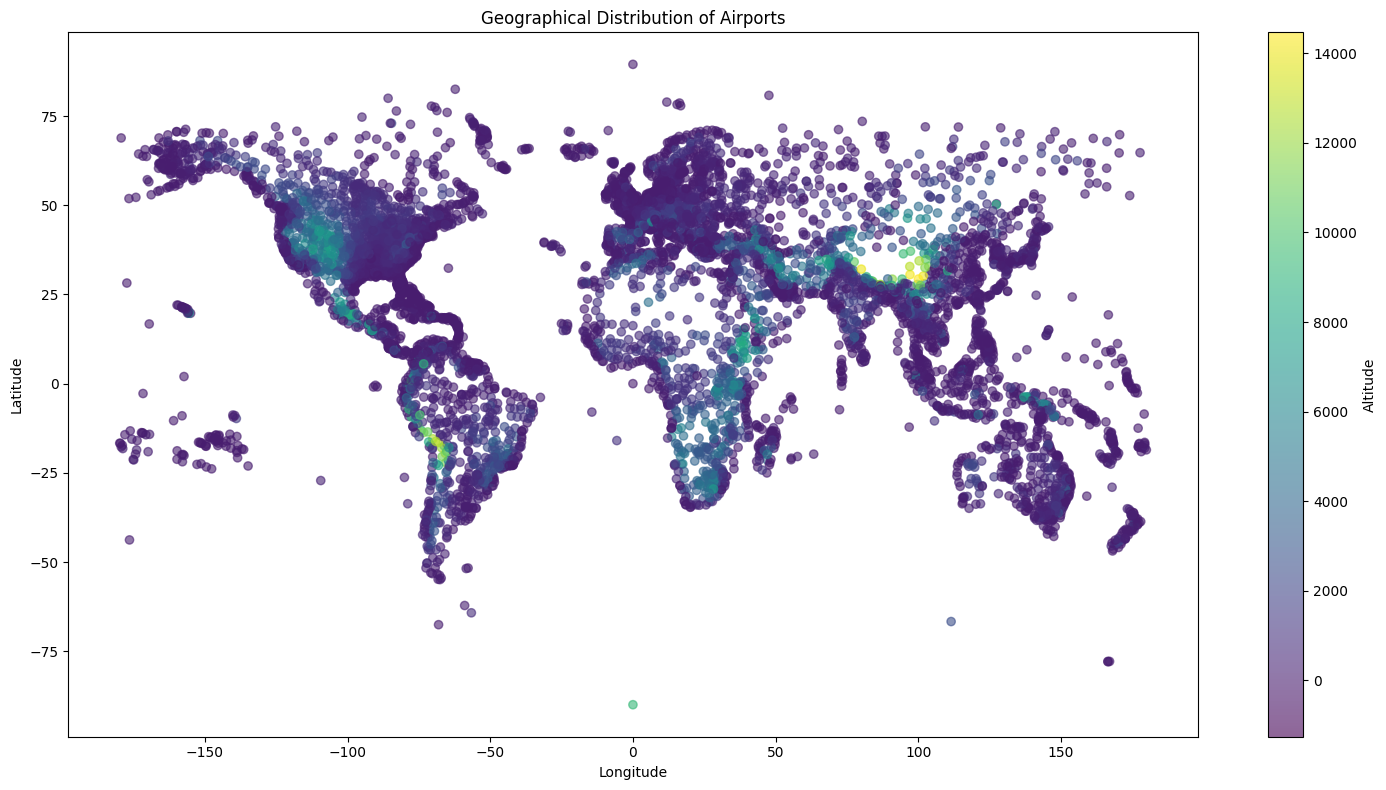

In [ ]:
plot_geographical_distribution(airports_df)

<ipython-input-127-7a731bc7d6cd>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(df['cluster'].unique()))  # Use a discrete color map


<Figure size 2000x1500 with 0 Axes>

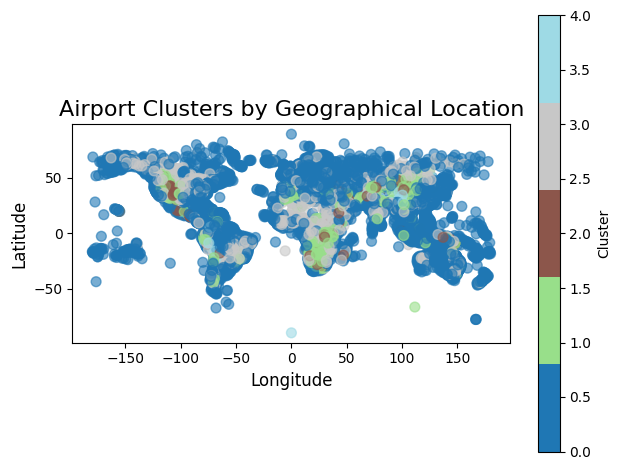

In [ ]:
plot_clusters_on_map(airports_df, kmeans)

In [ ]:
print("\nAirport Type Distribution:")
print(airports_df['type'].value_counts())

print("\nTop 5 Countries with Most Airports:")
print(airports_df['country'].value_counts().head())


Airport Type Distribution:
type
airport    7698
Name: count, dtype: int64

Top 5 Countries with Most Airports:
country
United States    1512
Canada            430
Australia         334
Russia            264
Brazil            264
Name: count, dtype: int64
